In this lecture, I will demonstrate how to do the spectroscopic data reduction using python. Since the concepts of the tasks, i.e., the procedures what you should do are clear, you must be able to do it via any language you can use.


## Literatures

Some useful materials to understand spectroscopic data reduction:
- [Wagner's writing in 1992](http://adsabs.harvard.edu/abs/1992ASPC...23..160W)
  - As far as I know, this is the most comprehensive writing about spectroscopic data reduction, including theoretical background and practical usage (using IRAF).
- [FOCAS cookbook](https://www.subarutelescope.org/Observing/DataReduction/Cookbooks/FOCAS_cookbook_2010jan05.pdf)
  - This is written specifically for FOCAS, and is few of available English manual for that specific instrument. It gives you idea about how to reduce data using IRAF.
  - Even though you are not using FOCAS, Sections 5, 6, and appendix B will generally be useful. Especially Section 5.5 (and 5.7) are very valuable.
- Among [IRAF archive](http://iraf.noao.edu/iraf-ftp.html), the writing by [Massey at al in 1992](ftp://iraf.noao.edu/ftp/docs/spect.ps.Z) is THE official manual to do spectroscopic data reduction in IRAF.

## Packages
As you can see, all the important materials are made for IRAF, not Python. I could only find few informative packages, including [PyDIS](https://github.com/jradavenport/pydis) by Dr. James Davenport. There is a currently ongoing discussion about making spectroscopy package in astropy, called [specutils](https://github.com/astropy/specutils). But currently, there is no useful packages so far. One of the most recent discussions about this issue on the Python users in Astronomy group was [this](https://www.facebook.com/groups/astropython/permalink/2473081482936527/), with no hope.

- Our lecture note's [references/](https://github.com/ysBach/AO2019/tree/master/references), find somethings related to spectroscopy.
- The astropy-affiliated package [``specutils``](https://specutils.readthedocs.io/en/stable/) is under development now. It is released in a "usable" form only in 2019. It's useful only after you obtained the 1-D spectrum from your data.
- You may benchmark [Pypeit](https://github.com/pypeit/PypeIt)


In short, there is currently no perfect python tools or packages to satisfactorily do the spectroscopic data reduction in python. So my basic philosophy in producing this material is

1. Make explicit codes step by step so that every process is visible.
   - This means I intentionally do not make package for all the processes. Only simple code snippets will be shown here.
   - As I am not an expert in programming (and I believe a scientist sometimes *should not* consider too much about this technical issues), the codes are never carefully optimized. But they work at least.
2. Make the code similar to IRAF.
   - This is basically because IRAF is still the *de facto* standard for spectroscopic data reduction. If I try to make some different approach than IRAF, it may require significant effort from my side (which is impossible due to the lack of my ability), and I do believe that IRAF is very carefully designed.
   
In the following, I show my own code, and **it can be extremely slow compared to optimized codes**. I didn't care much about technical details (faster calculation, etc), basically due to the lack of my ability plus time limits.

> The data which I used throughout this tutorial can be downloaded from my Dropbox link: [all files here](https://www.dropbox.com/sh/0mi77jj382n0wma/AADpwsNjmFtp34SZZ8i59P1sa?dl=0). [Only IRAF database folder files](https://www.dropbox.com/sh/ulfzya4fulhgtpm/AABGgwVOXfhKXqhZ1r7wXVvxa?dl=0) which contains identify and aperture trace. You can download it and compare it with your database files.
>
> I tried to compare the step-by-step results with IRAF. The cl script used are only the followings. Save it as ``test.cl`` and do 
>```
>    --> cl < test.cl
>```
> on IRAF or PyRAF. 
>
>    ```
>    noao
>    onedspec
>    twodspec
>    longslit
>    apextract
>    
>    identify pcomp_medcomb section="middle line" coordli='' funct=cheby order=4
>    reidentify pcomp_medcomb pcomp_medcomb section="middle line" override- trace- newaps- refit+ step=15 nsum=15 cradius=5 verbose+ 
>    apall pobj_mls170213_0025 find- resize- nsum=10 b_func=cheb b_order=3 b_nav=1 b_nit=5 t_nsum=10 t_step=10 t_func=cheb t_ord=3 t_nav=1 t_nit=5 background=fit skybox=1 pfit=fit1d
>    fitcoords pcomp_medcomb interac+
>    refspec pobj_mls170213_0025.ms reference=pcomp_medcomb sort='' group='' answer='yes'
>    dispcor pobj_mls170213_0025.ms[*,1,1] final_0025.fits
>    splot final_0025.fits
>    ```
>    **NOTE**: Be careful about re-doing any of the process! You MUST delete the pre-existing database files. Otherwise, IRAF will not re-write, but adds many lines to the pre-existing files...


## Preprocessing
**Note: I've never touched this part since 2017. This is left just for the legacy purpose. You'd better not use this.**

Since this is the second semester for AO takers of SNU, I didn't spend time for preprocessing. Simply follow this:

1. Download git to your computer from [here](https://git-scm.com/downloads)
2. Clone [this repo](https://github.com/ysBach/AO2_tutorial) by, e.g., ``git clone https://github.com/ysBach/AO2_tutorial``
3. Install by ``python3 setup.py install`` at the downloaded directory.

Then I used ``preprocess.py`` at ``data/45P`` of this repo.

## Postprocessing

This is the tricky part. There is no single best way, so we need a lot of interaction with computers. That includes

1. Wavelength identification (ID): First, you cut a small fraction of the comparison lamp image, and let the computer to calculate the wavelength $\lambda = \lambda(x)$ for given pixel value ``x``.
2. Reidentification (REID): Then you must check this function makes sense throughout the whole image. REID checks it.
3. Aperture trace (aptrace): The object spectrum cannot be perfectly parallel to the dispersion direction. Aptrace (in IRAF, ``APALL``) is to find how the source moves along the dispersion direction.
4. Sky subtraction: The sky should be subtracted *at each wavelength*.
5. Aperture sum: We then sum the pixel values within the selected aperture. 

### 0. Preparation

We first load the data, and set some variables to be used:

In [19]:
from pathlib import Path
import numpy as np

from numpy.polynomial.chebyshev import chebfit, chebval

%matplotlib notebook 
# comment above out when you copy this code to your spyder, etc.

from matplotlib import pyplot as plt
from matplotlib import gridspec, rcParams, rc
from matplotlib.widgets import Cursor

from astropy.table import Table, Column
from astropy.io import fits
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
from astropy.modeling.models import Gaussian1D, Chebyshev2D
from astropy.modeling.fitting import LevMarLSQFitter

from photutils.aperture import RectangularAperture, aperture_photometry

from skimage.feature import peak_local_max

def disable_mplkeymaps():
    rc('keymap', 
       fullscreen='',
       home='',
       back='',
       forward='',
       pan='',
       zoom='',
       save='',
       quit='',
       grid='',
       yscale='',
       xscale='',
       all_axes=''
       )
FONTSIZE = 12 # Change it on your computer if you wish.
rcParams.update({'font.size': FONTSIZE})

#%%
DATAPATH = Path('../data/45P')

DISPAXIS = 1  # 1 = line = python_axis_1 // 2 = column = python_axis_0
COMPIMAGE = DATAPATH/'pcomp_medcomb.fits' # Change directory if needed!
OBJIMAGE  = DATAPATH/'pobj_mls170213_0025.fits'
LINE_FITTER = LevMarLSQFitter()

# Parameters for IDENTIFY
FITTING_MODEL_ID = 'Chebyshev'
ORDER_ID = 4 
NSUM_ID = 10
FWHM_ID = 4 # rough guess of FWHM of lines in IDENTIFY (pixels)

# Parameters for REIDENTIFY
FITTING_MODEL_REID = 'Chebyshev' # 2-D fitting function
ORDER_SPATIAL_REID = 6
ORDER_WAVELEN_REID = 6
STEP_REID = 15  # Reidentification step size in pixels (spatial direction)
NSUM_REID = 10
TOL_REID = 5 # tolerence to lose a line in pixels

# Parameters for APALL (sky fitting and aperture extract after sky subtraction)
## parameters for finding aperture
NSUM_AP = 10
FWHM_AP = 10
STEP_AP = 10  # Recentering step size in pixels (dispersion direction)
## parameters for sky fitting
FITTING_MODEL_APSKY = 'Chebyshev'
ORDER_APSKY = 3
SIGMA_APSKY = 3
ITERS_APSKY = 5
## parameters for aperture tracing
FITTING_MODEL_APTRACE = 'Chebyshev'
ORDER_APTRACE = 3
SIGMA_APTRACE = 3
ITERS_APTRACE = 5 
# The fitting is done by SIGMA_APTRACE-sigma ITERS_APTRACE-iters clipped on the
# residual of data. 

#%%
lamphdu = fits.open(COMPIMAGE)
objhdu = fits.open(OBJIMAGE)
lampimage = lamphdu[0].data
objimage  = objhdu[0].data

if lampimage.shape != objimage.shape:
    raise ValueError('lamp and obj images should have same sizes!')

if DISPAXIS == 2:
    lampimage = lampimage.T
    objimage = objimage.T
elif DISPAXIS != 1:
    raise ValueError('DISPAXIS must be 1 or 2 (it is now {:d})'.format(DISPAXIS))

EXPTIME = objhdu[0].header['EXPTIME']
OBJNAME = objhdu[0].header['OBJECT']
# Now python axis 0 (Y-direction) is the spatial axis 
# and 1 (X-direciton) is the wavelength (dispersion) axis.
N_SPATIAL, N_WAVELEN = np.shape(lampimage)
N_REID = N_SPATIAL//STEP_REID # No. of reidentification
N_AP = N_WAVELEN//STEP_AP # No. of aperture finding

# ``peak_local_max`` calculates the peak location using maximum filter:
#   med1d_max = scipy.ndimage.maximum_filter(med1d, size=10, mode='constant')
# I will use this to show peaks in a primitive manner.
MINSEP_PK = 5   # minimum separation of peaks
MINAMP_PK = 0.01 # fraction of minimum amplitude (wrt maximum) to regard as peak
NMAX_PK = 50
print("setting done!")

setting done!


In the above code, I defined some parameters that will be used for the future codes. The variables with underbar is in the notation that ``parameter_task``, e.g., ``ORDER_ID`` = the order of fitting function for the task ID (identify). 

The most important thing I did is the part of ``DSIPAXIS``. I forced that ANY 2-D input data with proper ``DISPAXIS`` value to have the dispersion along x-axis (in python, ``axis=0`` is the Y-axis and ``axis=1`` is the X-axis, as many numerical languages: see [google search](https://www.google.co.kr/search?q=numpy+axis&newwindow=1&client=ubuntu&hs=KNf&channel=fs&dcr=0&source=lnms&tbm=isch&sa=X&ved=0ahUKEwj55aSH-53XAhXJUZQKHZ-IBNMQ_AUICigB&biw=1863&bih=909)). 

The meaning of other parameters will be clear in the following.

### 1. Identify (ID)

We now do the line identification. That is, we find "peaks" from our preprocessed data of comparison lamps (``pcomp_medcomb``). First cut it along dispersion axis so that we can see many peaks:

<IPython.core.display.Javascript object>


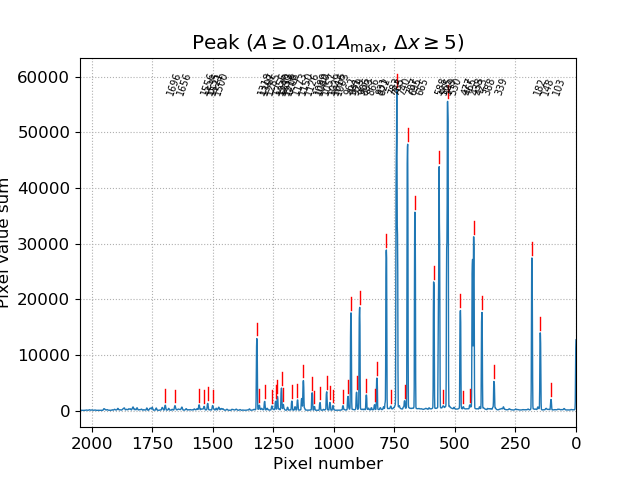

In [2]:
# =============================================================================
# Identify (1): plot for manual input
# =============================================================================
# mimics IRAF IDENTIFY
#   IDENTIIFY image.fits section='middle line' nsum=NSUM_ID
lowercut_ID = N_SPATIAL//2 - NSUM_ID//2 
uppercut_ID = N_SPATIAL//2 + NSUM_ID//2
identify_1 = np.median(lampimage[lowercut_ID:uppercut_ID, :], axis=0)

# For plot and visualization
max_intens = np.max(identify_1)

peak_pix = peak_local_max(identify_1, indices=True, num_peaks=NMAX_PK,
                          min_distance=MINSEP_PK,
                          threshold_abs=max_intens * MINAMP_PK)
# ``peak_pix`` corresponds to the x value, since x = pixels starting from 0.

disable_mplkeymaps()
fig = plt.figure()
ax = fig.add_subplot(111)
title_str = r'Peak ($A \geq {:.2f} A_\mathrm{{max}}$, $\Delta x \geq {:.0f}$)'
# Plot original spectrum + found peak locations
x_identify = np.arange(0, len(identify_1))
ax.plot(x_identify, identify_1, lw=1)

for i in peak_pix:
    ax.plot((i, i), 
            (identify_1[i]+0.01*max_intens, identify_1[i]+0.05*max_intens),
            color='r', ls='-', lw=1)
    ax.annotate(i[0], (i, 0.9),
                xycoords = ('data', 'axes fraction'),
                fontsize='xx-small', rotation=70)
ax.grid(ls=':')
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value sum')
ax.set_xlim(len(identify_1), 0) # to invert x-axis
ax.set_title(title_str.format(MINAMP_PK, MINSEP_PK))
plt.show()

In the plot, red vertical ticks are "local maxima" found by [``scikit.feature.peak_local_max``](http://scikit-image.org/docs/dev/api/skimage.feature.html#peak-local-max). On top, you can see the local peak in pixel numbers. They overlap a lot, so zoom in by yourself. 

* **QUESTION**: I intentionally inverted x-axis. Why do you think so?

* **TIP**: I also used ``NSUM_ID=10``, i.e., I summed 10 pixels around the middle line of the comparison lamp image. Why not just one-pixel-width line, or taking median? It has been a customary to use sum rather than median in spectroscopy. It is not clear for this comparison lamp image, but is visible for the object image, which I will show you later. For the lamp image, there is practically no difference as you can see from this code:
```python
fig, ax = plt.subplots(1,1)
test_sum = np.average(lampimage[lowercut_ID:uppercut_ID, :], axis=0)
test_med = np.median(lampimage[lowercut_ID:uppercut_ID, :], axis=0)
test_1px = lampimage[N_SPATIAL//2, :]
ax.plot(test_sum, lw=1, label='sum')
ax.plot(test_med, lw=1, label='med')
ax.plot(test_1px, lw=1, label='1pix')
ax.set_xlim(700, 1000)
ax.legend()
plt.show()
```

We are using NHAO MALLS comparison lamp, and the desired peaks with wavelength is given by the observatory ([here](http://www.nhao.jp/~malls/malls_wiki/index.php?MALLS%2F150%CB%DC%A5%B0%A5%EC%A1%BC%A5%C6%A5%A3%A5%F3%A5%B0%CD%D1%B5%B1%C0%FEID%CD%D1%A5%DE%A5%C3%A5%D7)). Comparing with this IRAF figure and the above plot, I could obtain the following table:

In [3]:
ID_init = dict(pixel_init=[1696, 1556, 1521, 1318, 1233, 1216, 1126, 1029,
                           929, 893, 822, 783, 695, 665, 588, 477, 388, 339, 182, 148],
               wavelength=[4764.865 , 5167.487 , 5269.537 , 5852.4878, 6096.163 , 6143.0627,
                           6402.248 , 6678.2766, 6965.431 , 7067.218 , 7272.936 , 7383.98  ,
                           7635.105 , 7723.761 , 7948.175 , 8264.521 , 8521.441 , 8667.944 ,
                           9122.967 , 9224.499 ])

If you prefer, you can make a pixel-to-angstrom table by a spread sheet app (e.g., Excel), save it as ``userid.csv``, and
```python
import pandas as pd
ID_init = pd.read_csv("userid.csv")
```
I just did it in python to visualize within the code. Now, the first column of ``ID_init`` is the initial guess, and the second column is the "true" wavelength values. The process to obtain the function to transform pixel to wavelength is two-fold:
1. Find the Gaussian-fitted peak of lines (from the initial guess ``ID_init["pixel_init"]``).
2. Fit that fitted peak (in pixel unit) and wavelengths (``ID_init["wavelength"]``).
3. The function to fit is Chebyshev (``FITTING_MODEL_ID``) of order 4(``ORDER_ID``), in this tutorial.

In [4]:
# Make it as astropy table
ID_init = Table(ID_init)

peak_gauss = []
fitter = LevMarLSQFitter()

for peak_pix in ID_init['pixel_init']:
    #TODO: put something like "lost_factor" to multiply to FWHM_ID in the bounds.
    g_init = Gaussian1D(amplitude = identify_1[peak_pix], 
                       mean = peak_pix, 
                       stddev = FWHM_ID * gaussian_fwhm_to_sigma,
                       bounds={'amplitude': (0, 2*identify_1[peak_pix]),
                               'mean':(peak_pix-FWHM_ID, peak_pix+FWHM_ID),
                               'stddev':(0, FWHM_ID)})
    fitted = LINE_FITTER(g_init, x_identify, identify_1)
    peak_gauss.append(fitted.mean.value)
    
peak_gauss = Column(data=peak_gauss, name='pixel_gauss', dtype=float)
peak_shift = Column(data=peak_gauss - ID_init['pixel_init'],
                    name='pixel_shift', dtype=float)
ID_init["pixel_gauss"] = peak_gauss
ID_init["pixel_shift"] = peak_gauss - ID_init['pixel_init']
ID_init.sort('wavelength')
ID_init.pprint()
# If you want to save:
# ID_init.write(DATAPATH/'user_input_identify.csv', 
#              format='ascii.csv', overwrite=True)

pixel_init wavelength    pixel_gauss          pixel_shift     
---------- ---------- ------------------ ---------------------
      1696   4764.865  1695.878619514806  -0.12138048519409494
      1556   5167.487 1556.1671063171361    0.1671063171361311
      1521   5269.537 1520.6643066059253    -0.335693394074724
      1318  5852.4878 1317.6900380750672   -0.3099619249328498
      1233   6096.163 1232.6657239974386  -0.33427600256140977
      1216  6143.0627 1216.2614314543616    0.2614314543616274
      1126   6402.248 1125.8365718131765   -0.1634281868234666
      1029  6678.2766  1029.459998826328   0.45999882632804656
       929   6965.431  929.1768323855434    0.1768323855434346
       893   7067.218  893.6440102765882     0.644010276588233
       822   7272.936  821.9787359295167 -0.021264070483312025
       783    7383.98   783.284202811702   0.28420281170201633
       695   7635.105  695.7771397627806    0.7771397627806209
       665   7723.761  664.9548036909357  -0.0451963090

The line findings are done clearly! The column means the central pixel after gaussian fitting, initial guess in pixel, the shift (difference between the two), and the true wavelength we had to manually put in.

Now, how can we fit? Simply using ``numpy``'s [Chebyshev module](https://www.google.co.kr/search?client=ubuntu&channel=fs&q=numpy+chebyshev&ie=utf-8&oe=utf-8&gfe_rd=cr&dcr=0&ei=LzjuWcWjMdCA0AT2zIboCA):

<IPython.core.display.Javascript object>


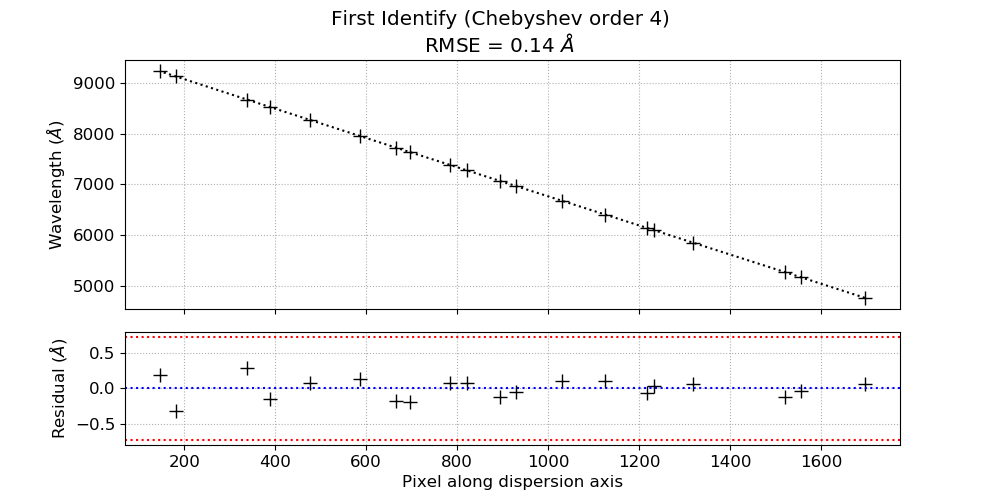

In [5]:
if FITTING_MODEL_ID.lower() == 'chebyshev':
    coeff_ID, fitfull = chebfit(ID_init['pixel_gauss'], 
                                ID_init['wavelength'], 
                                deg=ORDER_ID,
                                full=True)
    fitRMS = np.sqrt(fitfull[0][0]/len(ID_init))
    rough_error = ( np.ptp(ID_init['wavelength']) 
                   / np.ptp(ID_init['pixel_gauss']) ) / 2
    # rough_error = (wave_max - wave_min) / (spatial_max - spatial_min)
    residual = ( ID_init['wavelength'] 
                - chebval(ID_init['pixel_gauss'], coeff_ID))
    res_range = np.max(np.abs(residual))
else:
    raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_REID))

fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2])
ax2 = plt.subplot(gs[2])
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.plot(ID_init['pixel_gauss'], ID_init['wavelength'],
         ls=':', color='k', ms=10, marker='+')
ax2.plot(ID_init['pixel_gauss'], residual, 
         ls='', color='k', ms=10, marker='+')
ax2.axhline(y=0, color='b', ls=':')
# rough error ~ +- wavelength resolution/2
ax2.axhline(y=-rough_error/2, color='r', ls=':')
ax2.axhline(y=+rough_error/2, color='r', ls=':')
ax2.set_ylim(min(-rough_error/2 * 1.1, -1.1*res_range), 
             max(+rough_error/2 * 1.1, +1.1*res_range))
ax1.set_ylabel(r'Wavelength ($\AA$)')
ax2.set_ylabel(r'Residual ($\AA$)')
ax2.set_xlabel('Pixel along dispersion axis')
ax1.grid(ls=':')
ax2.grid(ls=':')
plt.suptitle(('First Identify (Chebyshev order {:d})\n'.format(ORDER_ID) 
              + r'RMSE = {:.2f} $\AA$'.format(fitRMS)))
plt.show()

As can be seen, the wavelngth decreases as increasing x-axis. The pixel coordinate can be transformed to wavelength with 0.14 Angstrom of RMS error. 

For comparison, I turned on the IRAF and obtained the following plots:

```
--> identify pcomp_medcomb section="middle line" coordli='' funct=cheby order=4
```
(IRAF plot has x-axis in wavelength unit, so it is inverted with respect to the above plot)
![](figs/identify_iraf.png)

* **TIP**: You MUST specify ``coordli=''`` in IRAF. If not, IRAF seems to internally change the user input wavelength. It compares the wavelength you put in with the internally stored line list, and changes your input to the closest wavelength. This will give unsatisfactorily large residuals (e.g., I got ~ 2 Angstroms). For cross check, I uploaded the ``idpcomp_medcomb`` file [here](https://drive.google.com/open?id=0B-MLFRYnMxUvUTdJdG80V1VVYzg). Delete ``_BACKUP`` from the filename and save it to the ``database/`` as IRAF default and run ``IDENTIFY`` for check.

### 2. Re-identify (REID)

From identify process (ID), we used only the middle row of the image, not the whole 2-D image. If it were a perfect spectrograph, we expect the wavelength must not vary along the spatial (slit) direction. But in reality, it is possible that ``(x, y) = (1000, 100)`` can have different wavelength value compared to ``(x, y) = (1000, 300)``. Re-identification (REID) deals with such 2-D wavelength variation. 

1. We will find the same lines as we did from identify (ID) for many different rows. For each row, there will be fitted line centers (pixel) and the true wavelengths.
2. For 2-D image, the locations of the line peaks are now specified, and thus we have to find $\lambda = \lambda(x, y)$. 

In [7]:
# =============================================================================
# reidentify
# =============================================================================
# For REIDENTIFY, I used astropy.modeling.models.Chebyshev2D

line_REID = np.zeros((len(ID_init), N_REID-1))
spatialcoord = np.arange(0, (N_REID - 1) * STEP_REID, STEP_REID) + STEP_REID / 2

print('Reidentify each section by Chebyshev (order {:d})'.format(ORDER_ID))
print('section      |  found  |  RMS')

for i in range(0, N_REID-1):
    lower_cut, upper_cut = i*STEP_REID, (i+1)*STEP_REID
    reidentify_i = np.sum(lampimage[lower_cut:upper_cut, :], 
                          axis=0)
    peak_gauss_REID = []
    
    for peak_pix_init in ID_init['pixel_gauss']:
        # TODO: Will a simple astropy fitting work well for general cases?
        #TODO: put something like "lost_factor" to multiply to FWHM_ID in the bounds.
        search_min = int(np.around(peak_pix_init - TOL_REID))
        search_max = int(np.around(peak_pix_init + TOL_REID))
        cropped = reidentify_i[search_min:search_max]
        x_cropped = np.arange(len(cropped)) + search_min
        
        #TODO: put something like "lost_factor" to multiply to FWHM_ID in the bounds.
        A_init = np.max(cropped)
        mean_init = peak_pix_init
        stddev_init = FWHM_ID * gaussian_fwhm_to_sigma
        g_init = Gaussian1D(amplitude=A_init, mean=mean_init, stddev=stddev_init,
                            bounds={'amplitude':(0, 2*np.max(cropped)) ,
                                    'stddev':(0, TOL_REID)})
        g_fit = fitter(g_init, x_cropped, cropped)    
        fit_center = g_fit.mean.value
        if abs(fit_center - peak_pix_init) > TOL_REID:
            peak_gauss_REID.append(np.nan)
            continue
        peak_gauss_REID.append(fit_center)

    peak_gauss_REID = np.array(peak_gauss_REID)
    nonan_REID = np.isfinite(peak_gauss_REID)
    line_REID[:, i] = peak_gauss_REID
    peak_gauss_REID_nonan = peak_gauss_REID[nonan_REID]
    n_tot = len(peak_gauss_REID)
    n_found = np.count_nonzero(nonan_REID)
    
    if FITTING_MODEL_ID.lower() == 'chebyshev':
        coeff_REID1D, fitfull = chebfit(peak_gauss_REID_nonan,
                                        ID_init['wavelength'][nonan_REID], 
                                        deg=ORDER_WAVELEN_REID,
                                        full=True)
        fitRMS = np.sqrt(fitfull[0][0]/n_found)
    
    else:
        raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_REID))

    print('[{:04d}:{:04d}]\t{:d}/{:d}\t{:.3f}'.format(lower_cut, upper_cut,
                                                      n_found, n_tot, fitRMS))

Reidentify each section by Chebyshev (order 4)
section      |  found  |  RMS
[0000:0015]	17/20	0.842
[0015:0030]	17/20	0.995
[0030:0045]	19/20	0.987
[0045:0060]	20/20	0.951
[0060:0075]	20/20	0.909
[0075:0090]	20/20	0.901
[0090:0105]	20/20	0.919
[0105:0120]	20/20	0.652
[0120:0135]	20/20	0.762
[0135:0150]	20/20	0.095
[0150:0165]	20/20	0.117
[0165:0180]	20/20	0.119
[0180:0195]	20/20	0.093
[0195:0210]	20/20	0.126
[0210:0225]	20/20	0.127
[0225:0240]	20/20	0.139
[0240:0255]	20/20	0.127
[0255:0270]	20/20	0.134
[0270:0285]	20/20	0.122
[0285:0300]	20/20	0.115
[0300:0315]	20/20	0.117
[0315:0330]	20/20	0.109
[0330:0345]	20/20	0.105
[0345:0360]	20/20	0.160
[0360:0375]	20/20	0.150
[0375:0390]	20/20	0.178
[0390:0405]	20/20	0.142
[0405:0420]	20/20	0.152
[0420:0435]	20/20	0.148
[0435:0450]	20/20	0.123
[0450:0465]	20/20	0.118
[0465:0480]	20/20	0.111
[0480:0495]	20/20	0.152
[0495:0510]	20/20	0.117
[0510:0525]	20/20	0.094
[0525:0540]	20/20	0.092
[0540:0555]	20/20	0.105
[0555:0570]	20/20	0.090
[0570:0585]

The printed output shows the sections ``[row_min:row_max]`` used for the ``i``-th reidentification, number of successfully found lines over all the lines, and the 4th order 1-D Chebyshev fitting RMS errors. The criterion for "found" lines is simple: ``abs(fit_center - peak_pix_init) > TOL_REID``, i.e., the fitted center from reidentify at given row should not be far from the result of the identify process (closer than ``TOL_REID``).

FYI, IRAF results can be found after you do ``REIDENTIFY``:

``` 
--> reidentify pcomp_medcomb pcomp_medcomb section="middle line" override- trace- newaps- refit+ step=15 nsum=15 cradius=5 verbose+ 
```

Now let me show you how to fit the 2-D Chebyshev surface to this reidentified data. 

In [8]:
points = np.vstack((line_REID.flatten(),
                    np.tile(spatialcoord, len(line_REID))))
points = points.T # list of ()
nanmask = ( np.isnan(points[:,0]) | np.isnan(points[:,1]) )
points = points[~nanmask]
values = np.repeat(ID_init['wavelength'], N_REID - 1)
values = np.array(values.tolist())
values = values[~nanmask]
errors = np.ones_like(values)

if FITTING_MODEL_REID.lower() == 'chebyshev':
    coeff_init = Chebyshev2D(x_degree=ORDER_WAVELEN_REID, y_degree=ORDER_SPATIAL_REID)
    fit2D_REID = fitter(coeff_init, points[:, 0], points[:, 1], values)
    ww, ss = np.mgrid[:N_WAVELEN, :N_SPATIAL]
else:
    raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_REID))

You may ignore the possible ``WARNING``. What I do here is to flatten the ``x, y`` values, and fit it to [``Chebyshev2D`` of astropy](http://docs.astropy.org/en/stable/api/astropy.modeling.polynomial.Chebyshev2D.html#astropy.modeling.polynomial.Chebyshev2D). The plot is:

<IPython.core.display.Javascript object>


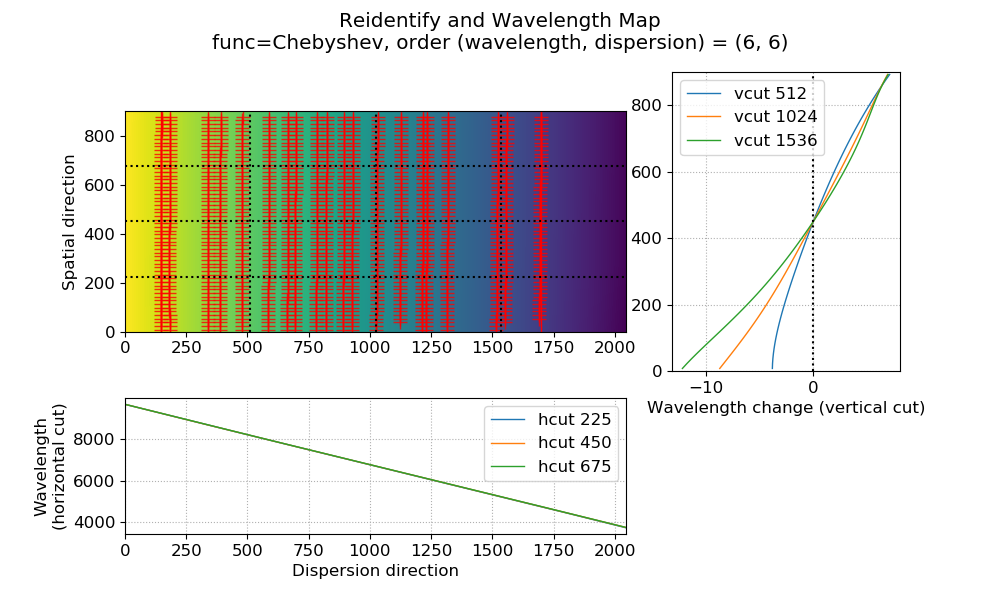

In [11]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[:2, :2])
ax2 = plt.subplot(gs[2, :2])
ax3 = plt.subplot(gs[:2, 2])
#plt.setp(ax2.get_xticklabels(), visible=False)
#plt.setp(ax3.get_yticklabels(), visible=False)

title_str = ('Reidentify and Wavelength Map\n'
             + 'func=Chebyshev, order (wavelength, dispersion) = ({:d}, {:d})')
plt.suptitle(title_str.format(ORDER_WAVELEN_REID, ORDER_SPATIAL_REID))

interp_min = line_REID[~np.isnan(line_REID)].min()
interp_max = line_REID[~np.isnan(line_REID)].max()

ax1.imshow(fit2D_REID(ww, ss).T, origin='lower')
ax1.axvline(interp_max, color='r', lw=1)
ax1.axvline(interp_min, color='r', lw=1)
#ax1.text((interp_max+interp_min)/2, -10, "Fitting Region",
#         horizontalalignment="center",
#         bbox={'facecolor':'red', 'alpha':0.8, 'pad':10})
ax1.plot(points[:, 0], points[:, 1], ls='', marker='+', color='r',
         alpha=0.8, ms=10)


for i in (1, 2, 3):
    vcut = N_WAVELEN * i/4
    hcut = N_SPATIAL * i/4
    vcutax  = np.arange(0, N_SPATIAL, STEP_REID) + STEP_REID/2
    hcutax  = np.arange(0, N_WAVELEN, 1)
    vcutrep = np.repeat(vcut, len(vcutax))
    hcutrep = np.repeat(hcut, len(hcutax))
    
    ax1.axvline(x=vcut, ls=':', color='k')   
    ax1.axhline(y=hcut, ls=':', color='k')
    
    ax2.plot(hcutax, fit2D_REID(hcutax, hcutrep), lw=1, 
             label="hcut {:d}".format(int(hcut)))

    vcut_profile = fit2D_REID(vcutrep, vcutax)
    vcut_normalize = vcut_profile - np.median(vcut_profile)
    ax3.plot(vcut_normalize, vcutax, lw=1,
             label="vcut {:d}".format(int(vcut)))

ax1.set_ylabel('Spatial direction')
ax2.grid(ls=':')
ax2.legend()
ax2.set_xlabel('Dispersion direction')
ax2.set_ylabel('Wavelength\n(horizontal cut)')

ax3.axvline(0, ls=':', color='k')
ax3.grid(ls=':', which='both')
ax3.set_xlabel('Wavelength change (vertical cut)')
ax3.legend()

ax1.set_ylim(0, N_SPATIAL)
ax1.set_xlim(0, N_WAVELEN)
ax2.set_xlim(0, N_WAVELEN)
ax3.set_ylim(0, N_SPATIAL)
plt.show()

In the plot, I showed 
* The Chebyshev 2D fitting to the x, y coordinates. The color means fitted wavelengths (basically a 3-D plot).
* The red ``+`` markers are the REID results. 
  * Although may not be clearly identifiable, I also showed two red vertical lines to show the min/max of interpolation regions. Outside this region, the fitting may not be very reliable.
* The right panel shows the vertical cuts of 1/4, 2/4, and 3/4 of x-range. 
  * Along the y-axis, you can see how much the (fitted) wavelength changes as fraction. 0.001 means 6 Angstroms for the orange line (since wavelength ~ 6000).
* The bottom pannel shows the wavelength with respect to the x-axis. 
  * It is seen that all the three horizontal cuts do not differ too much.

From the right diagram, it is seen that the wavelength does not change much if the pixels changed ~ 100 pixel along the spatial direction (y-axis). 

In IRAF, you can use [``FITCOORDS``](http://stsdas.stsci.edu/cgi-bin/gethelp.cgi?fitcoords) to see similar, but different plots. If you run 

```
--> fitcoords pcomp_medcomb interac+
```

You will see the residual with respect to x-axis. Please refer to the literature "FOCAS cookbook" section 5 to find information about ``FITCOORDS``. Basically I hit ``xxyyf`` to get the left panel of the figure below. This is similar to the ``+`` markers of the figure above. It's not identical, since this is the "expected line peaks based on the 2D Chebyshev fit". It is not showing you the re-identified positions but expected positions. 

Then I hit ``xxyrf`` and ``w``-``e``-``e`` as in ``IMPLOT`` or whatever plotting tools of IRAF to zoom in one of the vertical set of ``+`` markers (right panel). You can see that the re-identified line centers fluctuate in x-axis (~ 4 pixels). 

![](figs/fitcoords_iraf.png)


3. Aperture Extraction

Since the position of the object along the dispersion axis is NOT necessarily on a single row, we have to find how it moves along the dispersion axis. This moving trace is called the aperture trace, and our goal is to find the position of the signal as a function of x-axis pixel.

1. Crop the middle column and interactively set the initial peak location (rough guess) and sky estimation region.
2. Check how the sky is fitted. Subtract sky and fit Gaussian to find the aperture center (center of the object).
3. Iteratively find the aperture along the dispersion direction. 
   - From the Gaussian fits we found here, estimate the FWHM as the median of all the fitted Gaussians' FWHMs.
4. Fit aperture trace (here I used Chebyshev order 3): y =y (x)
5. Now, for all the columns, fit sky, subtract sky, and get the aperture sum. Use the fitted aperture trace as true center, sum the pixels around it (I used +- 2-sigma)


<IPython.core.display.Javascript object>


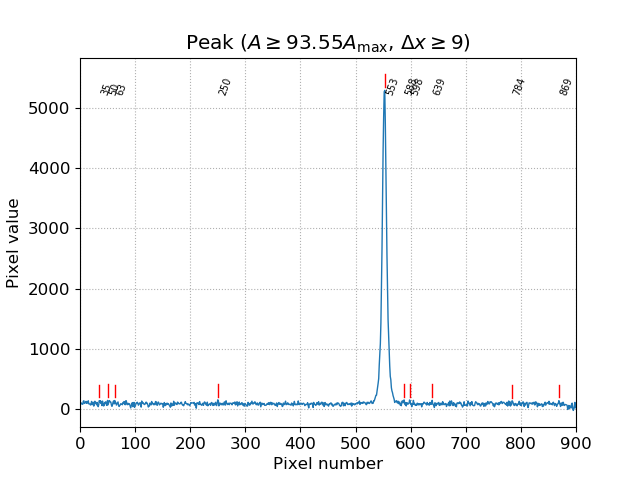

In [12]:
# =============================================================================
# apall (1): Plot a cut
# =============================================================================
lower_cut = N_WAVELEN//2 - NSUM_AP//2 
upper_cut = N_WAVELEN//2 + NSUM_AP//2
apall_1 = np.sum(objimage[:, lower_cut:upper_cut], axis=1)
max_intens = np.max(apall_1)

peak_pix = peak_local_max(apall_1, indices=True, num_peaks=10,
                          min_distance=int(N_SPATIAL/100),
                          threshold_abs=np.median(apall_1))

x_apall = np.arange(0, len(apall_1))

fig = plt.figure()
ax = fig.add_subplot(111)
title_str = r'Peak ($A \geq {:.2f} A_\mathrm{{max}}$, $\Delta x \geq {:.0f}$)'

ax.plot(x_apall, apall_1, lw=1)

for i in peak_pix:
    ax.plot((i, i), 
            (apall_1[i]+0.01*max_intens, apall_1[i]+0.05*max_intens),
            color='r', ls='-', lw=1)
    ax.annotate(i[0], (i, 0.9),
                xycoords = ('data', 'axes fraction'),
                fontsize='xx-small', rotation=70)
ax.grid(ls=':')
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value')
ax.set_xlim(0, len(apall_1))
ax.set_title(title_str.format(np.median(apall_1), int(N_SPATIAL/100)))
plt.show()

From the plot, I can see that ``x=553`` can be a good guess of the object center. I will use some regions nearby it for sky estimation.

<IPython.core.display.Javascript object>


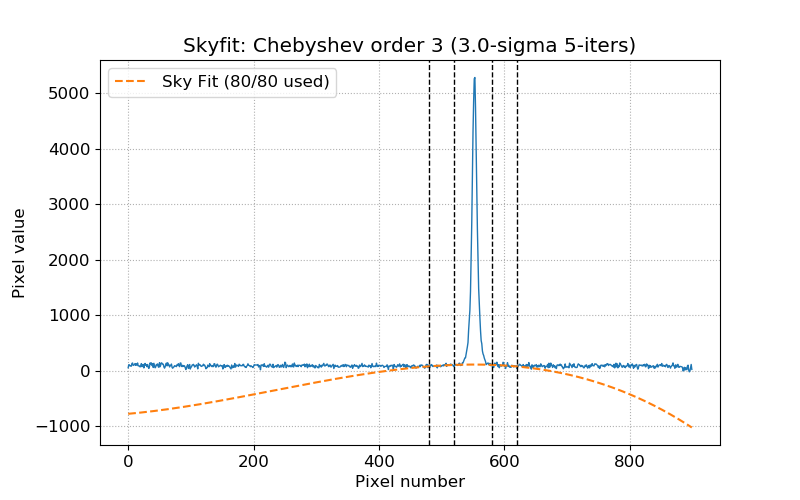

In [14]:
# =============================================================================
# apall(2): manually select sky, see how the fit works
# =============================================================================
ap_init = 553

ap_sky = np.array([480, 520, 580, 620])
# Regions to use as sky background. xl1 - 1, xu1, xl2 - 1, xu2. (0-indexing)
#   Sky region should also move with aperture center!
#   from ``ap_center - 50`` to ``ap_center - 40``, for example, should be used.
# TODO: accept any even-number-sized ap_sky.

# Interactive check
x_sky = np.hstack( (np.arange(ap_sky[0], ap_sky[1]), 
                    np.arange(ap_sky[2], ap_sky[3])))
sky_val = np.hstack( (apall_1[ap_sky[0]:ap_sky[1]], 
                      apall_1[ap_sky[2]:ap_sky[3]]))

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
title_str = r'Skyfit: {:s} order {:d} ({:.1f}-sigma {:d}-iters)'
ax.plot(x_apall, apall_1, lw=1)

if FITTING_MODEL_APSKY.lower() == 'chebyshev':
    # TODO: maybe the clip is "3-sigma clip to residual and re-fit many times"?
    clip_mask = sigma_clip(sky_val, sigma=SIGMA_APSKY, maxiters=ITERS_APSKY).mask
    coeff_apsky, fitfull = chebfit(x_sky[~clip_mask], 
                                   sky_val[~clip_mask],
                                   deg=ORDER_APSKY,
                                   full=True)
    fitRMS = np.sqrt(fitfull[0][0]/n_found)
    n_sky = len(x_sky)
    n_rej = np.count_nonzero(clip_mask)
    sky_fit = chebval(x_apall, coeff_apsky) 
    ax.plot(x_apall, sky_fit, ls='--',
            label='Sky Fit ({:d}/{:d} used)'.format(n_sky - n_rej, n_sky))
    ax.plot(x_sky[clip_mask], sky_val[clip_mask], marker='x', ls='', ms=10)
    [ax.axvline(i, lw=1, color='k', ls='--') for i in ap_sky]
    ax.legend()
    ax.set_title(title_str.format(FITTING_MODEL_APSKY, ORDER_APSKY,
                                  SIGMA_APSKY, ITERS_APSKY))
    ax.set_xlabel('Pixel number')
    ax.set_ylabel('Pixel value sum')
    
else:
    raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_REID))
ax.grid(ls=':')
ax.set_xlabel('Pixel number')
ax.set_ylabel('Pixel value')
plt.show()

Although the skyfit does not seem to work at far from the object (since it's extrapolation), it should work for the object region since it's interpolation. 

Now I do the aperture trace fit:

In [16]:
# =============================================================================
# apall (3): aperture trace
# =============================================================================
# within +- 100 pixels around the aperture, the wavelength does not change much
# as can be seen from reidentify figure 
# (in NHAO case, ~ 0.01% ~ 0.1 Angstrom order).
# So it's safe to assume the wavelength is constant over around such region,
# (spatial direction) and thus I will do sky fitting from this column,
# without considering the wavelength change along a column.
# Then aperture extraction will map the pixel to wavelength using aperture
# trace solution.

aptrace = []
aptrace_fwhm = []
#coeff_apsky = []
#aptrace_apsum = []
#aptrace_wavelen = []

# TODO: This is quite slow as for loop used: improvement needed.
# I guess the problem is sigma-clipping rather than fitting process..
for i in range(N_AP - 1):
    lower_cut, upper_cut = i*STEP_AP, (i+1)*STEP_AP
    
    apall_i = np.sum(objimage[:, lower_cut:upper_cut], axis=1)
    sky_val = np.hstack( (apall_i[ap_sky[0]:ap_sky[1]], 
                          apall_i[ap_sky[2]:ap_sky[3]]))
    
    # Subtract fitted sky
    if FITTING_MODEL_APSKY.lower() == 'chebyshev':
        # TODO: maybe we can put smoothing function as IRAF APALL's b_naverage 
        clip_mask = sigma_clip(sky_val, sigma=SIGMA_APSKY, maxiters=ITERS_APSKY).mask
        coeff, fitfull = chebfit(x_sky[~clip_mask], 
                                 sky_val[~clip_mask],
                                 deg=ORDER_APSKY,
                                 full=True)
        apall_i -= chebval(x_apall, coeff)
#        fitRMS = np.sqrt(fitfull[0][0]/n_found)
#        n_sky = len(x_sky)
#        n_rej = np.count_nonzero(clip_mask)
    
    else:
        raise ValueError('Function {:s} is not implemented.'.format(FITTING_MODEL_APSKY))

    #TODO: put something like "lost_factor" to multiply to FWHM_ID in the bounds.
    search_min = int(np.around(ap_init - 3*FWHM_AP))
    search_max = int(np.around(ap_init + 3*FWHM_AP))
    cropped = apall_i[search_min:search_max]
    x_cropped = np.arange(len(cropped))
    peak_pix = peak_local_max(cropped, 
                              min_distance=FWHM_AP,
                              indices=True,
                              num_peaks=1)
    if len(peak_pix) == 0:
        aptrace.append(np.nan)
        continue
    peak_pix = peak_pix[0][0]
    
    #TODO: put something like "lost_factor" to multiply to FWHM_ID in the bounds.
    g_init = Gaussian1D(amplitude=cropped[peak_pix], 
                       mean=peak_pix, 
                       stddev=FWHM_AP * gaussian_fwhm_to_sigma,
                       bounds={'amplitude':(0, 2*cropped[peak_pix]) ,
                               'mean':(peak_pix-3*FWHM_AP, peak_pix+3*FWHM_AP),
                               'stddev':(0, FWHM_AP)})
    fitted = fitter(g_init, x_cropped, cropped)
    center_pix = fitted.mean.value + search_min
    std_pix = fitted.stddev.value
    aptrace_fwhm.append(fitted.fwhm)
    aptrace.append(center_pix)
#    coeff_apsky.append(coeff)
#    aptrace_apsum.append(apsum)
#    apsum_lower = int(np.around(center_pix - apsum_sigma_lower * std_pix))
#    apsum_upper = int(np.around(center_pix + apsum_sigma_upper * std_pix))
#    apsum = np.sum(apall_i[apsum_lower:apsum_upper])

aptrace = np.array(aptrace)
aptrace_fwhm = np.array(aptrace_fwhm)
#coeff_apsky = np.array(coeff_apsky)
#aptrace_apsum = np.array(aptrace_apsum)

/Users/ysbach/anaconda3/lib/python3.7/site-packages/astropy/modeling/functional_models.py:166: RuntimeWarning: divide by zero encountered in true_divide
  return amplitude * np.exp(- 0.5 * (x - mean) ** 2 / stddev ** 2)


You may ignore ``RuntimeWarning``.

Here I left some part of the codes for those who want to check/test the code.

Now, for every ``STEP_AP`` columns (in our tutorial 10), find the object center and plot it:

<IPython.core.display.Javascript object>


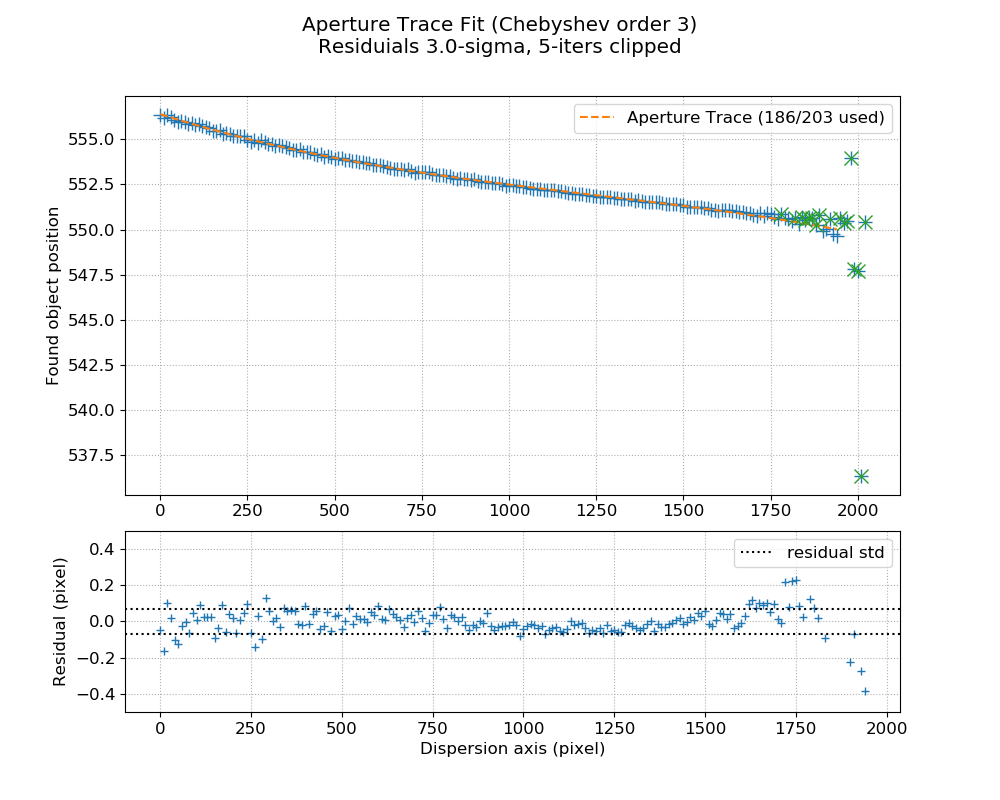

In [18]:
# =============================================================================
# apall(4): aperture trace fit
# =============================================================================
x_aptrace = np.arange(N_AP-1) * STEP_AP

coeff_aptrace = chebfit(x_aptrace, aptrace, deg=ORDER_APTRACE)
resid_mask = sigma_clip(aptrace - chebval(x_aptrace, coeff_aptrace), 
                        sigma=SIGMA_APTRACE, maxiters=ITERS_APTRACE).mask

x_aptrace_fin = x_aptrace[~resid_mask]
aptrace_fin = aptrace[~resid_mask]
coeff_aptrace_fin = chebfit(x_aptrace_fin, aptrace_fin, deg=ORDER_APTRACE)
fit_aptrace_fin   = chebval(x_aptrace_fin, coeff_aptrace_fin)
resid_aptrace_fin = aptrace_fin - fit_aptrace_fin
del_aptrace = ~np.in1d(x_aptrace, x_aptrace_fin) # deleted points

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2], sharex=ax2)
ax2 = plt.subplot(gs[2])

title_str = ('Aperture Trace Fit ({:s} order {:d})\n'
            + 'Residuials {:.1f}-sigma, {:d}-iters clipped')
plt.suptitle(title_str.format(FITTING_MODEL_APTRACE, ORDER_APTRACE,
                              SIGMA_APTRACE, ITERS_APTRACE))
ax1.plot(x_aptrace, aptrace, ls='', marker='+', ms=10)
ax1.plot(x_aptrace_fin, fit_aptrace_fin, ls='--',
         label="Aperture Trace ({:d}/{:d} used)".format(len(aptrace_fin), N_AP-1))
ax1.plot(x_aptrace[del_aptrace], aptrace[del_aptrace], ls='', marker='x', ms=10)
ax1.legend()
ax2.plot(x_aptrace_fin, resid_aptrace_fin, ls='', marker='+')
#ax2.plot(x_aptrace, aptrace - chebval(x_aptrace, coeff_aptrace_fin), 
#         ls='', marker='+')
ax2.axhline(+np.std(resid_aptrace_fin, ddof=1), ls=':', color='k')
ax2.axhline(-np.std(resid_aptrace_fin, ddof=1), ls=':', color='k', 
            label='residual std')

ax1.set_ylabel('Found object position')
ax2.set_ylabel('Residual (pixel)')
ax2.set_xlabel('Dispersion axis (pixel)')
ax1.grid(ls=':')
ax2.grid(ls=':')
ax2.set_ylim(-.5, .5)
ax2.legend()
plt.show()
#plt.savefig('aptrace.png', bbox_inches='tight')

In [ ]:
# =============================================================================
# apall(5): aperture sum
# =============================================================================
apsum_sigma_lower = 2.104 # See below
apsum_sigma_upper = 2.130 
# lower and upper limits of aperture to set from the center in gauss-sigma unit.
ap_fwhm = np.median(aptrace_fwhm[~resid_mask])
ap_sigma = ap_fwhm * gaussian_fwhm_to_sigma
apheight = (apsum_sigma_lower + apsum_sigma_upper)*ap_sigma

x_ap = np.arange(N_WAVELEN)
y_ap = chebval(x_ap, coeff_aptrace_fin)
ap_wavelen = fit2D_REID(x_ap, y_ap)
ap_sky_offset = ap_sky - ap_init

ap_summed  = []
data_skysub = []

for i in range(N_WAVELEN):
    cut_i = objimage[:, i].copy()
    ap_sky_i = int(y_ap[i]) + ap_sky_offset
   
    x_sky = np.hstack( (np.arange(ap_sky_i[0], ap_sky_i[1]),
                        np.arange(ap_sky_i[2], ap_sky_i[3])))
    sky_val = np.hstack( (cut_i[ap_sky_i[0]:ap_sky_i[1]],
                          cut_i[ap_sky_i[2]:ap_sky_i[3]]))
    clip_mask = sigma_clip(sky_val, sigma=SIGMA_APSKY, maxiters=ITERS_APSKY).mask
   
    coeff = chebfit(x_sky[~clip_mask],
                    sky_val[~clip_mask],
                    deg=ORDER_APSKY)

    data_skysub.append(cut_i - chebval(np.arange(cut_i.shape[0]), coeff))

data_skysub = np.array(data_skysub).T
hdr = objhdu[0].header
hdr.add_history(f"Sky subtracted using sky offset = {ap_sky_offset}, "
                + f"{SIGMA_APSKY}-sigma {ITERS_APSKY}-iter clipping "
                + f"to fit order {ORDER_APSKY} Chebyshev")
_ = fits.PrimaryHDU(data=data_skysub, header=hdr)
_.data = _.data.astype('float32')
_.writeto(DATAPATH/(OBJIMAGE.stem+".skysub.fits"), overwrite=True)

In the code, ``apsum_sigma_lower`` and ``upper`` are set as such strange floating number to match the IRAF manual reduction. When I did the IRAF manual spectrum extraction, the generated ``apall`` file (stored in ``database/apBLAHBLAH``) says

    ...
    center	1024. 553.6911
	low	-1023. -8.617371
	high	1024. 8.722351
    ...

i.e., the sigmas should be selected such that ``apsum_sigma_lower * ap_sigma = -8.617371`` and ``apsum_sigma_upper * ap_sigma = 8.722351``. So I set ``apsum_sigma_lower = 2.104`` and ``apsum_sigma_upper = 2.130``. 

Now ``data_skysub`` is sky-subtracted, we don't have to worry about sky value at all. Therefore, just put apertures and do aperture photometry using rectangular aperture:

In [44]:
pos = np.array([x_ap, y_ap]).T
aps = RectangularAperture(positions=pos, w=1, h=apheight, theta=0)
phot = aperture_photometry(data_skysub, aps, method='subpixel', subpixels=10)
ap_summed = phot['aperture_sum'] / EXPTIME

Originally I used my crude code until 2019 AO2:
```python
ap_summed  = []

for i in range(N_WAVELEN):
    cut_i = objimage[:, i]
    ap_sky_i = int(y_ap[i]) + ap_sky_offset
   
    lower = y_ap[i] - apsum_sigma_lower * ap_sigma
    upper = y_ap[i] + apsum_sigma_upper * ap_sigma + 1
    # + 1 required since python regards, e.g., list[1:3] = list[1], list[2] (NOT list[3] included).
    
    x_obj_lower = int(np.around(y_ap[i] - apsum_sigma_lower * ap_sigma))
    x_obj_upper = int(np.around(y_ap[i] + apsum_sigma_upper * ap_sigma)) 
    x_obj = np.arange(x_obj_lower, x_obj_upper)
    obj_i = cut_i[x_obj_lower:x_obj_upper]
   
    l_pix_w = x_obj_lower - lower - 0.5
    u_pix_w = upper - x_obj_upper - 0.5
   
    x_sky = np.hstack( (np.arange(ap_sky_i[0], ap_sky_i[1]),
                        np.arange(ap_sky_i[2], ap_sky_i[3])))
    sky_val = np.hstack( (cut_i[ap_sky_i[0]:ap_sky_i[1]],
                          cut_i[ap_sky_i[2]:ap_sky_i[3]]))
    clip_mask = sigma_clip(sky_val, sigma=SIGMA_APSKY, iters=ITERS_APSKY).mask
   
    coeff = chebfit(x_sky[~clip_mask],
                    sky_val[~clip_mask],
                    deg=ORDER_APSKY)

    obj_i -= chebval(x_obj, coeff)

    l_pix_val = obj_i[0] * l_pix_w   # negative value (hopefully)
    u_pix_val = obj_i[-1] * u_pix_w  # negative value (hopefully)

    ap_summed.append(np.sum(obj_i)+l_pix_val+u_pix_val)
#    print(lower, upper, ap_summed[i])
   
ap_summed = np.array(ap_summed) / EXPTIME
```

I then compare it with the IRAF result. I saved it as ``~~~.ms.fits`` file (download it from : [here](https://www.dropbox.com/s/kc1cocrtt5bza0g/pobj_mls170213_0025.ms.fits?dl=0)), so

<IPython.core.display.Javascript object>


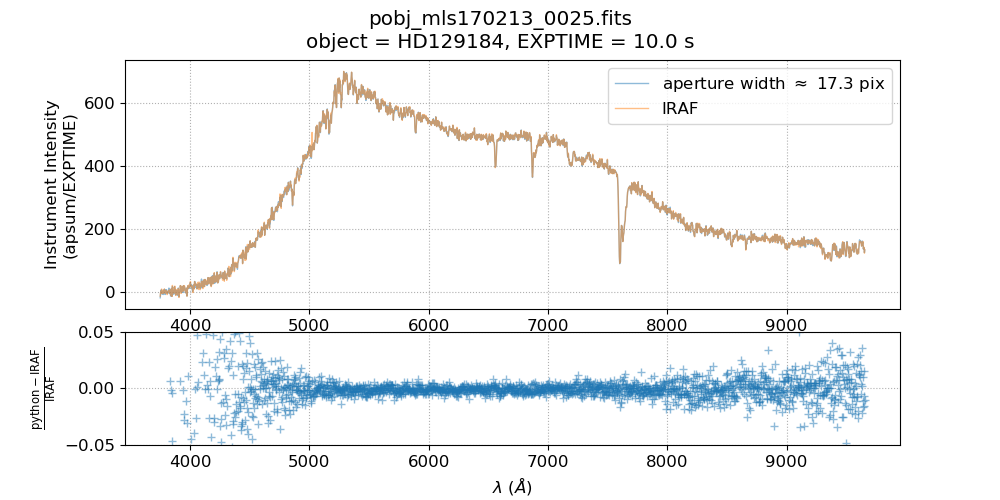

In [45]:
TESTIRAF = fits.open(DATAPATH/'pobj_mls170213_0025.ms.fits')
TESTIRAF = TESTIRAF[0].data[0,0,:]

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(3, 1)
ax1 = plt.subplot(gs[0:2])
ax2 = plt.subplot(gs[2])
#plt.setp(ax1.get_xticklabels(), visible=False)

title_str = '{:s}\nobject = {:s}, EXPTIME = {:.1f} s'
label_str = r'aperture width $\approx$ {:.1f} pix'
plt.suptitle(title_str.format(OBJIMAGE.name,
                              OBJNAME, EXPTIME))
ax1.plot(ap_wavelen, ap_summed, lw = 1,
         alpha=0.5,
         label=label_str.format(apheight))
ax1.plot(ap_wavelen, TESTIRAF/EXPTIME, lw = 1,
        alpha=0.5, label='IRAF')
ax2.plot(ap_wavelen, (ap_summed - TESTIRAF/EXPTIME)/(TESTIRAF/EXPTIME), 
         ls='', alpha=0.5, marker='+')
ax1.set_ylabel('Instrument Intensity\n(apsum/EXPTIME)')
ax2.set_ylabel(r'$\frac{\mathrm{python} - \mathrm{IRAF}}{\mathrm{IRAF}}$')
ax2.set_xlabel(r'$\lambda$ ($\AA$)')
ax2.set_ylim(-0.05, +0.05)
ax1.grid(ls=':')
ax2.grid(ls=':')

ax1.legend()
plt.show()





Some large residuals at short and long wavelength limits are most likely due to low S/N ratio, which results in non-identical aperture trace and thus aperture sum. At these wavelength limits, aperture sums are dominated by noises, so it's not unrealistic to have this kind of errors.

A slight deviation is acceptable since my python code may not EXACTLY resemble the IRAF code. 

* **NOTE**: I am not sure why yet but if you run the ``apall(5): aperture sum`` again and plot it, the resulting plot is not as desired. You have to load the image again and do ``apall(5): aperture sum`` again. Maybe I made a mistake..??